# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [50]:
# put all runtime variables in this cell

# for kaggle, 

steps_per_epoch=30  #100
validation_steps=10  #50
epochs = 3             # 50

early_stopping_patience = 5     

# PROJ_DIR='/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816'
KAGGLE_INPUT_DIR='/kaggle/input'
KAGGLE_WORKING_DIR='/kaggle/working'

# https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
# originally 240,240
# size=(150,150)
image_w = 224
image_h = 224

In [51]:
# setup environment

%pip install kaggle
%pip install pandas
%pip install seaborn
%pip install scipy
%pip install pickle

import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import tensorflow as tf
# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers

import pickle
import json


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip in

In [52]:
print(tf.__version__)


2.10.0


In [53]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, description=""):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.suptitle(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    ax.text(-2, 14, 
            description, 
            style='italic',
            bbox={'facecolor': 'red', 'alpha': 0.1, 'pad': 10}
            )

In [54]:
# reset data dir
import os,sys


STORE_DIR=os.path.join(KAGGLE_WORKING_DIR, '00_ds_landing')
DATA_DIR=os.path.join(KAGGLE_WORKING_DIR, '01_data')
TMP_DIR=os.path.join(KAGGLE_WORKING_DIR, '02_tmp')
MODEL_DIR=os.path.join(KAGGLE_WORKING_DIR, '03_model')

DATA_TRAIN_DIR=os.path.join(DATA_DIR,"train")
DATA_VALID_DIR=os.path.join(DATA_DIR,"valid")
DATA_TEST_DIR=os.path.join(DATA_DIR,"test")

# !rm -rf {PROJ_DIR}/data/*
# !rm -rf {DATA_DIR}/*

!mkdir -p {STORE_DIR}
!mkdir -p {DATA_DIR}
!mkdir -p {MODEL_DIR}
!mkdir -p {TMP_DIR}

!mkdir -p {DATA_TRAIN_DIR}
!mkdir -p {DATA_VALID_DIR}
!mkdir -p {DATA_TEST_DIR}


In [ ]:
# copy test dataset
!cp -r {KAGGLE_INPUT_DIR}/ml-vinniesniper-54816-test/* {DATA_TEST_DIR}

!cp -r {KAGGLE_INPUT_DIR}/ml-vinniesniper-54816-train/*  {STORE_DIR}

In [7]:
# Each species of flower is contained in a separate folder. Get all the sub directories
image_types = os.listdir(STORE_DIR)
print("Types of images found: ", len(image_types))
print("Categories of images: ", image_types)

Types of images found:  10
Categories of images:  ['dish', 'horse', 'man', 'beach', 'bus', 'building', 'flower', 'elephant', 'mountain', 'dinosaur']


In [8]:
# clean image
import os

num_skipped = 0
for folder_name in image_types:
    folder_path = os.path.join(STORE_DIR, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
            continue

        with open(fpath, "rb") as f:
            contents = f.read()
            if contents.startswith(b"\xff\xd8") and contents.endswith(b"\xff\xd9"):
                # it's a jpeg
                pass
            else:
                # print(file_path, "is not valid jpeg")
                os.remove(fpath)
                num_skipped += 1


print(f"Deleted {num_skipped} images.")

Deleted 1699 images.


In [9]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)

ds_images = []

for species in image_types:
    # Get all the file names
    all_flowers = os.listdir(STORE_DIR +"/"+ species)
    # Add them to the list
    for flower in all_flowers:
        ds_images.append((species, str(STORE_DIR +"/"+species) + '/' + flower))

# Build a dataframe        
ds_images = pd.DataFrame(data=ds_images, columns=['category', 'image'], index=None)
ds_images.head()


,category,image
0,dish,/kaggle/working/00_ds_landing/dish/c_000001061...
1,dish,/kaggle/working/00_ds_landing/dish/c_000000367...
2,dish,/kaggle/working/00_ds_landing/dish/c_000000095...
3,dish,/kaggle/working/00_ds_landing/dish/c_000000524...
4,dish,/kaggle/working/00_ds_landing/dish/c_000000463...


In [10]:
# Let's check how many samples for each category are present

print("Total number of images in the dataset: ", len(ds_images))
ds_image_count = ds_images['category'].value_counts()
print("images in each category: ")
print(ds_image_count)

Total number of images in the dataset:  49246
images in each category: 
category
horse       10345
dish         8244
dinosaur     6707
elephant     4665
beach        4472
bus          3972
flower       3711
mountain     3590
building     3351
man           189
Name: count, dtype: int64


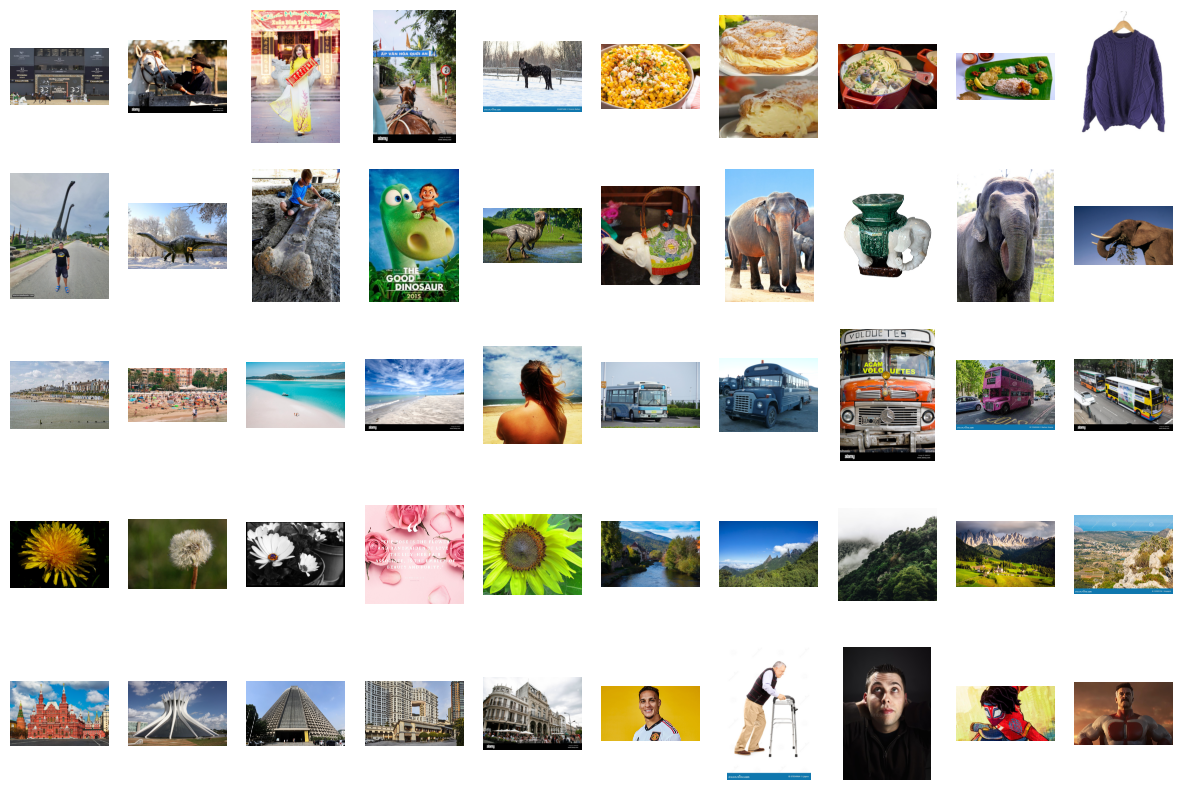

In [11]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in ds_image_count.index:
    samples = ds_images['image'][ds_images['category'] == category].sample(5).values
    for sample in samples:
        random_samples.append(sample)

# # Plot the samples
f, ax = plt.subplots(5,10, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//10,i%10].imshow(mimg.imread(random_samples[i]))
    ax[i//10,i%10].axis('off')
plt.show()    


In [12]:
# prepare train and validation directories for each categories

for type in image_types:
    %mkdir -p {DATA_TRAIN_DIR}/{type}
    %mkdir -p {DATA_VALID_DIR}/{type}

In [ ]:
# landing data according to category

for category in ds_image_count.index:
    samples = ds_images['image'][ds_images['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.move(samples[i],os.path.join(DATA_VALID_DIR , str(category) , name))

    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.move(samples[i],os.path.join(DATA_TRAIN_DIR, str(category) , name))

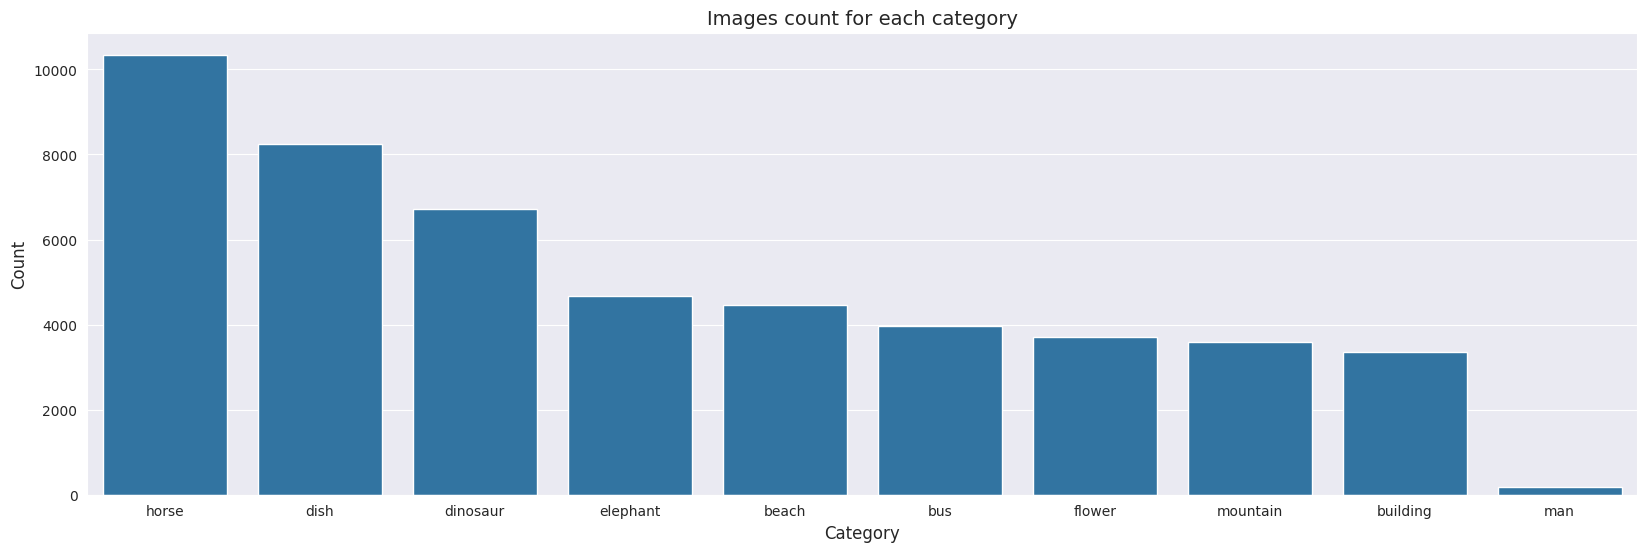

In [14]:
# Let's do some visualization and see how many samples we have for each category

f, axe = plt.subplots(1,1,figsize=(20,6))
sns.barplot(x = ds_image_count.index, y = ds_image_count.values, ax = axe)

axe.set_title("Images count for each category", fontsize=14)
axe.set_xlabel('Category', fontsize=12)
axe.set_ylabel('Count', fontsize=12)

plt.show()

In [15]:
# prepare base model, VGG16

from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_w, image_h, 3)
)

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    # starting from block5_conv1, train the layers and layers following
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Feature Extraction

In [16]:
# prepare overlay model

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(image_types), activation='softmax'))


model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [17]:
# generate dataset for test, valid, train

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
        )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        DATA_TRAIN_DIR,
        shuffle=True,
        target_size=(image_w, image_h),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical'  # more than two classes
)

validation_generator = val_datagen.flow_from_directory(
        DATA_VALID_DIR,
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

test_generator = test_datagen.flow_from_directory(
        DATA_TEST_DIR,
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)



Found 48477 images belonging to 10 classes.
Found 1004 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [18]:
test_generator.target_size

(224, 224)

In [19]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_acc', 
    mode='max', patience=early_stopping_patience,  
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,# originally 6 epochs
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
    )

Epoch 1/3


2024-11-22 16:43:24.958839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 16:43:25.163583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 16:43:25.163639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 16:43:25.163695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-22 16:43:25.163730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

30/30 [==============================] - ETA: 0s - loss: 0.4129 - acc: 0.1375

2024-11-22 16:43:57.285723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 16:43:57.350429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 16:43:57.350472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 16:43:57.350501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-22 16:43:57.350515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

30/30 [==============================] - 45s 1s/step - loss: 0.4129 - acc: 0.1375 - val_loss: 0.3222 - val_acc: 0.1063
Epoch 2/3
30/30 [==============================] - 42s 1s/step - loss: 0.3145 - acc: 0.2938 - val_loss: 0.2899 - val_acc: 0.3406
Epoch 3/3
30/30 [==============================] - 41s 1s/step - loss: 0.2795 - acc: 0.3958 - val_loss: 0.2197 - val_acc: 0.4938


In [ ]:
# archive result

model.save(MODEL_DIR+'/model.h5')

with open(MODEL_DIR+'/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

with open(MODEL_DIR+'/model_architecture.json', 'w') as f:
    f.write(model.to_json())

history.history.keys()


INFO:tensorflow:Assets written to: ram://d0f1c674-62cc-43c4-a0a1-315779f275b1/assets


INFO:tensorflow:Assets written to: ram://d0f1c674-62cc-43c4-a0a1-315779f275b1/assets


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

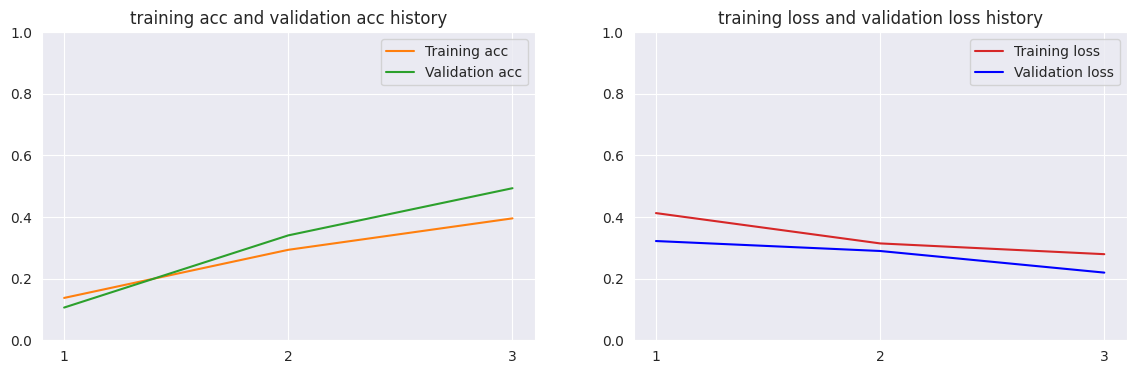

In [44]:
# plot train and validation accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
graph_epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].set_title('training acc and validation acc history')
axes[0].plot(graph_epochs, acc, 'tab:orange', label='Training acc')
axes[0].plot(graph_epochs, val_acc, 'tab:green', label='Validation acc')
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1))
axes[0].set_ylim([0,1])
axes[0].legend()

axes[1].set_title('training loss and validation loss history')
axes[1].plot(graph_epochs, loss, 'tab:red', label='Training loss')
axes[1].plot(graph_epochs, val_loss, 'b', label='Validation loss')
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1))
axes[1].set_ylim([0,1])
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [31]:
model_3_val = val_acc[-1]
print("final Validation Accuracy: ", model_3_val)

final Validation Accuracy:  0.4937500059604645


2024-11-22 16:45:35.527867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 29s 908ms/step


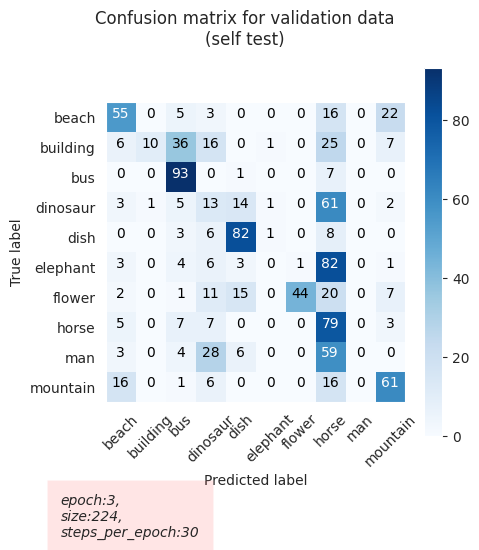

In [49]:
# model self test on validation data

validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(
    title='Confusion matrix for validation data\n(self test)',
    cm = con_mat, 
    classes = validation_generator.class_indices.keys(), 
    normalize = False,
    description="epoch:{},\nsize:{},\nsteps_per_epoch:{}".format(str(len(history.epoch)), str(image_w), str(steps_per_epoch))
    )

32/32 [==============================] - 28s 899ms/step


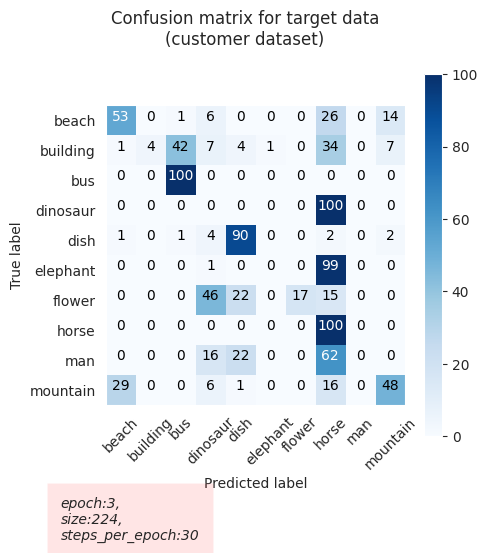

In [ ]:
# model self test on target data

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(test_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(
    title='Confusion matrix for target data\n(customer dataset)',
    cm = con_mat, 
    classes = test_generator.class_indices.keys(), 
    normalize = False,
    description="epoch:{},\nsize:{},\nsteps_per_epoch:{}".format(str(epochs), str(image_w), str(steps_per_epoch))
    )

2439130/2439130 [==============================] - 0s 0us/step


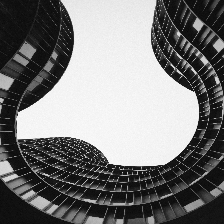

In [35]:
!rm -rf /home/logic/.keras/datasets/Red_sunflower
# bus
sunflower_url = "https://images.unsplash.com/photo-1540457943340-2e70b692e50e"
# sunflower_url = "https://images.unsplash.com/photo-1590951360207-317cb18098b3"
# sunflower_url = "https://images.unsplash.com/photo-1491378630646-3440efa57c3b"
# sunflower_url = "https://images.unsplash.com/photo-1499190263783-18a53a561660"
sunflower_url = "https://images.unsplash.com/photo-1527576539890-dfa815648363"

# sunflower_url = "https://images.unsplash.com/photo-1544954412-78da2cfa1a0c"
# sunflower_url = "https://images.unsplash.com/photo-1550927049-d07581451e3c"
# sunflower_url = "https://images.unsplash.com/photo-1462216589242-9e3e00a47a48"
# sunflower_url = "https://images.unsplash.com/photo-1533523611631-15e4ef69be08"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# train
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/train/tulips/17189526216_fa24dd541a_n.jpg"

# validation
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/dandelion/10683189_bd6e371b97.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/roses/159079265_d77a9ac920_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"

img = tf.keras.utils.load_img(    sunflower_path, target_size=(image_h, image_w))

img


In [36]:
class_names = list(validation_generator.class_indices.keys())

import pandas as pd

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

data = np.array([class_names,predictions[0]])
print(pd.DataFrame(data))


1/1 [==============================] - 0s 94ms/step
       0         1    2         3     4         5       6      7    8  \
0  beach  building  bus  dinosaur  dish  elephant  flower  horse  man   
1    0.0       0.0  0.0       0.0   1.0       0.0     0.0    0.0  0.0   

          9  
0  mountain  
1       0.0  


2024-11-22 16:46:33.704230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### 85% Accuracy using VGG16.